In [1]:
#!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':"10j84-2-Z_zedUTONXsu8AG1GS0ehQNIB"})   # replace the id with id of file you want to access
downloaded.GetContentFile('images101.zip')        # replace the file name with your file

In [4]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/tacos/1023154.jpg  
  inflating: images/tacos/1023947.jpg  
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/11097

# Transfer Learning from MobileNet 101 Class

In [5]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

HEIGHT = 224
WIDTH = 224

base_model = MobileNetV2(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [6]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "images"
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function= preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

Found 101000 images belonging to 101 classes.


In [7]:
from google.colab import files
uploaded = files.upload()

Saving classes.txt to classes.txt


In [8]:
classes_file = open("classes.txt", "r")
class_complete = classes_file.read().split('\n')
class_complete.pop()

''

In [9]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True #False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = class_complete
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [10]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [73]:
NUM_EPOCHS = 20
BATCH_SIZE = 101
num_train_images = 101000

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "MobileNetV2" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]


history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)

Epoch 1/20
1000/1000 [==============================] - ETA: 0s - loss: 1.2789 - accuracy: 0.6794
Epoch 00001: saving model to ./checkpoints/MobileNetV2_model_weights.h5
1000/1000 [==============================] - 122s 122ms/step - loss: 1.2789 - accuracy: 0.6794
Epoch 2/20
1000/1000 [==============================] - ETA: 0s - loss: 1.2623 - accuracy: 0.6709
Epoch 00002: saving model to ./checkpoints/MobileNetV2_model_weights.h5
1000/1000 [==============================] - 121s 121ms/step - loss: 1.2623 - accuracy: 0.6709
Epoch 3/20
1000/1000 [==============================] - ETA: 0s - loss: 1.2371 - accuracy: 0.6830
Epoch 00003: saving model to ./checkpoints/MobileNetV2_model_weights.h5
1000/1000 [==============================] - 120s 120ms/step - loss: 1.2371 - accuracy: 0.6830
Epoch 4/20
1000/1000 [==============================] - ETA: 0s - loss: 1.2525 - accuracy: 0.6777
Epoch 00004: saving model to ./checkpoints/MobileNetV2_model_weights.h5
1000/1000 [========================

In [12]:
#acc_history = []
#loss_history = []

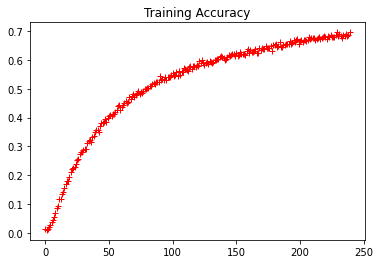

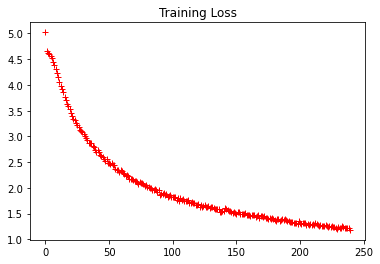

In [74]:
# Plot the training and validation loss + accuracy
acc_history = acc_history + history.history['accuracy']
loss_history = loss_history + history.history['loss']

# plot acc
plt.plot(range(len(acc_history)), acc_history, 'r+')
plt.title('Training Accuracy')
plt.savefig('plot_acc.jpg')
plt.show()

# plot loss
plt.plot(range(len(loss_history)), loss_history, 'r+')
plt.title('Training Loss')
plt.savefig('plot_loss.jpg')
plt.show()

# Save Accuracy and Loss History to text using numpy array

In [76]:
#import numpy as np

numpy_accuracy = np.array(acc_history)
numpy_loss = np.array(loss_history)
np.savetxt('acc_history_full.txt', numpy_accuracy)
np.savetxt('loss_history_full.txt', numpy_loss)

# Save Model to GDrive

In [77]:
finetune_model.save("101class_model_mobilenet_full11.h5") 

In [35]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [78]:
!cp 101class_model_mobilenet_full11.h5 '/content/gdrive/My Drive/Downloads/'
!ls -lt '/content/gdrive/My Drive/Downloads/' 

total 7932205
-rw------- 1 root root 812250700 Dec 14 08:47 101class_model_mobilenet_full11.h5
-rw------- 1 root root 812250700 Dec 14 07:55 101class_model_mobilenet_full10.h5
-rw------- 1 root root 812250700 Dec 14 07:08 101class_model_mobilenet_full9.h5
-rw------- 1 root root 812250700 Dec 14 06:23 101class_model_mobilenet_full8.h5
-rw------- 1 root root 812250700 Dec 14 05:39 101class_model_mobilenet_full7.h5
-rw------- 1 root root 812250700 Dec 14 04:56 101class_model_mobilenet_full6.h5
-rw------- 1 root root 812250700 Dec 14 04:14 101class_model_mobilenet_full5.h5
-rw------- 1 root root 812250700 Dec 14 03:26 101class_model_mobilenet_full4.h5
-rw------- 1 root root 812250700 Dec 14 02:44 101class_model_mobilenet_full3.h5
-rw------- 1 root root 812250700 Dec 14 01:59 101class_model_mobilenet_full2.h5
-rw------- 1 root root     65567 Dec 12 06:26 PizzaHut.jpg
